In [1]:
import numpy as np
def data_generate(num, dim, dist = 2.0, sigma = 1.0):
    x = np.zeros(shape = (num, dim,))
    y = np.zeros(shape = (num,))
    rand = np.random.rand(num)
    inds = rand < 0.2
    theta = np.zeros(shape = (dim,))
    theta[0] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.2, rand < 0.5)
    theta = np.zeros(shape = (dim,))
    theta[0] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = 1
    inds = np.logical_and(rand >= 0.5, rand < 0.9)
    theta = np.zeros(shape = (dim,))
    theta[1] = -dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    inds = rand >= 0.9
    theta = np.zeros(shape = (dim,))
    theta[1] = dist
    x[inds] = np.random.normal(loc = theta, scale = sigma, size = (inds.sum(), dim,))
    y[inds] = -1
    return x, y
    

In [2]:
import cvxpy as cp
def erm_logistic(x, y):
    dim = x.shape[1]
    theta = cp.Variable(dim)
    intercept = cp.Variable()
    logistic = cp.sum(cp.logistic(-cp.multiply(y, cp.matmul(x, theta) + intercept * np.ones_like(y))))
    obj = cp.Minimize(logistic)
    prob = cp.Problem(obj,)
    prob.solve(solver = cp.MOSEK)
    return theta.value, intercept.value

In [3]:
import cvxpy as cp
from scipy.special import xlogy
def grad_logistic(x, y, theta, intercept):
    num = x.shape[0]
    dim = x.shape[1]
    grad = np.zeros(shape = (num, theta.shape[0] + 1,))
    inds = np.multiply(y, np.matmul(x, theta) + intercept) < 1.0
    grad[inds, :dim] = -np.einsum('i,ij->ij', np.divide(1.0, 1.0 + np.exp(np.multiply(y[inds], np.matmul(x[inds, :], theta) + intercept))), np.einsum('i,ij->ij', y[inds], x[inds, :]))
    grad[inds, dim:] = -np.einsum('i,ij->ij', np.divide(1.0, 1.0 + np.exp(np.multiply(y[inds], np.matmul(x[inds, :], theta) + intercept))), np.reshape(y[inds], (-1, 1)))
    return grad

def uncert(x, theta, intercept, uncertain = 'entropy'):
    q = np.divide(1.0, 1.0 + np.exp(-(np.matmul(x, theta) + intercept)))
    if uncertain == 'entropy':
        return -(xlogy(q, q) + xlogy(1.0 - q, 1.0 - q))
    elif uncertain == 'leastconf':
        return np.minimum(q, 1.0 - q)
    else:
        print("uncertainty should be \'entropy\' or \'leastconf\'")
        return

def grad_equiv(x, y, theta, intercept, uncertain = 'entropy'):
    return np.average(np.einsum('i,ij->ij', uncert(x, theta, intercept, uncertain), grad_logistic(x, y, theta, intercept)), axis = 0)

def erm_equiv(x, y, tol = 1e-10, max_iter = 1e5, step_size = 1e-2, is_print = False, uncertain = 'entropy', init = None):
    dim = x.shape[1]
    if init is None:
    # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    grad = grad_equiv(x, y, theta, intercept, uncertain)
    count = 0
    while np.linalg.norm(grad) > tol:
        theta -= grad[:dim] * step_size
        intercept -= grad[dim:] * step_size
        grad = grad_equiv(x, y, theta, intercept, uncertain)
        count += 1
        if is_print and count % 1000 == 0:
            print(count, np.linalg.norm(grad))
        if count > max_iter:
            print("max_iter")
            break
    return theta, intercept[0]

In [4]:
x, y = data_generate(num = 10000, dim = 2, dist = 2.0, sigma = 0.5)

In [5]:
theta_logistic, inter_logistic = erm_logistic(x, y)

In [6]:
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=3e-2, max_iter = 2e5, uncertain = 'entropy')

max_iter


In [8]:
import matplotlib.pyplot as plt

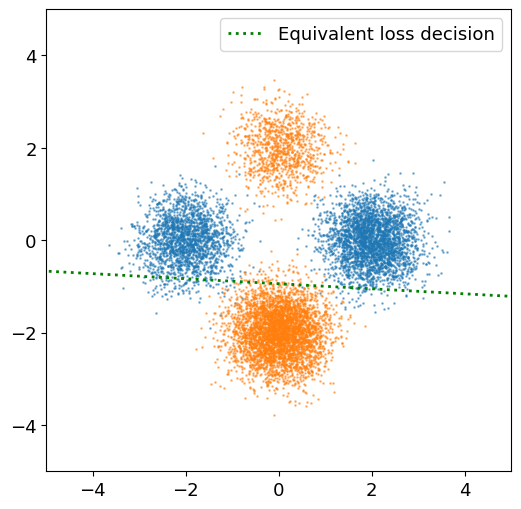

In [9]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [14]:
theta_eq1_1 = np.copy(theta_eq1)
inter_eq1_1 = np.copy(inter_eq1)

In [58]:
init = np.array([0.0, -0.5, 0.5])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=3e-2, max_iter = 2e5, uncertain = 'entropy', init = init)

max_iter


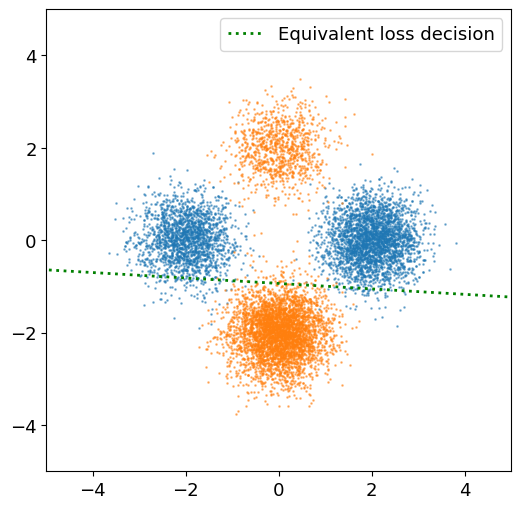

In [59]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [60]:
theta_eq1_2 = np.copy(theta_eq1)
inter_eq1_2 = np.copy(inter_eq1)

In [98]:
init = np.array([1.0, -0.04, -1.0])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=3e-3, max_iter = 1e5, uncertain = 'entropy', init = init)

max_iter


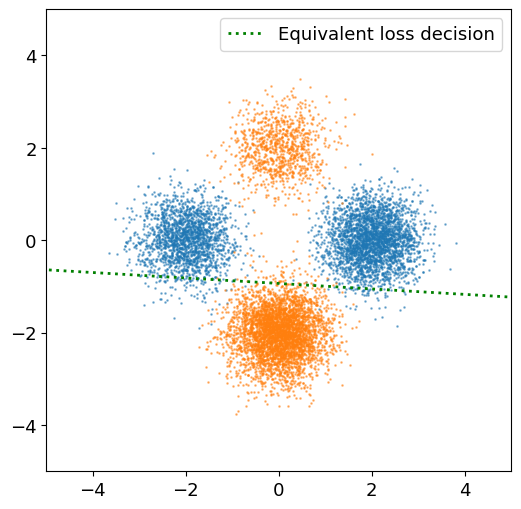

In [99]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [31]:
theta_eq1_3 = np.copy(theta_eq1)
inter_eq1_3 = np.copy(inter_eq1)

In [85]:
init = np.array([0.02, -0.5, 0.5])
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=5e-3, max_iter = 2e5, uncertain = 'entropy', init = init)

max_iter


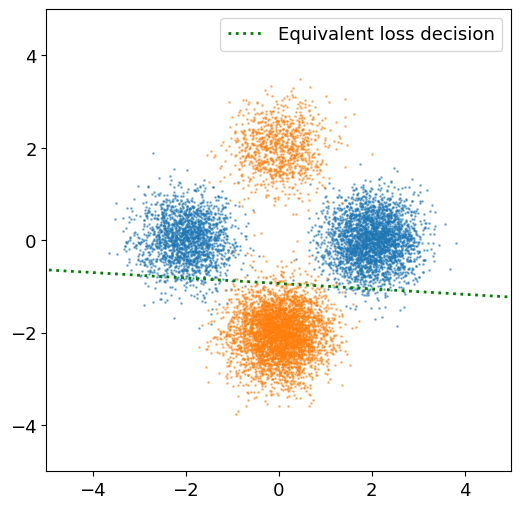

In [88]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
# init = np.array([0.02, -0.5, 0.5])
# hori_ini = (-init[2] - init[1] * vert_grid) / init[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 2.0)
# plt.plot(hori_ini, vert_grid, linestyle = 'dotted', alpha = 1.0, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [82]:
theta_eq1_4 = np.copy(theta_eq1)
inter_eq1_4 = np.copy(inter_eq1)

In [10]:
from tqdm import tqdm
def uncertain_sampling(x, y, max_iter = 1e6, step_size = 1e-3, uncertain = 'entropy', init = None):
    num = x.shape[0]
    dim = x.shape[1]
    if init is None:
        # Random initialization
        theta = np.random.normal(size = dim)
        intercept = np.random.normal(size = (1,))
    else:
        theta = init[:dim]
        intercept = init[dim:]
    for count in tqdm(range(int(max_iter))):
        sample = np.random.randint(low=0, high=num)
        U = uncert(x[sample], theta, intercept, uncertain)
        tmp = np.random.rand()
        if tmp <= U:
            grad = grad_logistic(np.reshape(x[sample], (1, -1)), np.atleast_1d(y[sample]), theta, intercept).flatten()
            theta -= grad[:dim] * step_size
            intercept -= grad[dim:] * step_size
    return theta, intercept[0]

In [11]:
theta_us1, inter_us1 = uncertain_sampling(x, y, max_iter = 1e7, step_size = 1e-4, init = None)

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [06:08<00:00, 27130.29it/s]


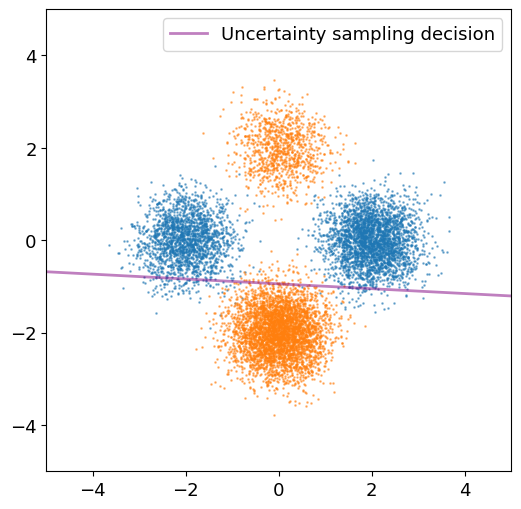

In [12]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.5, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


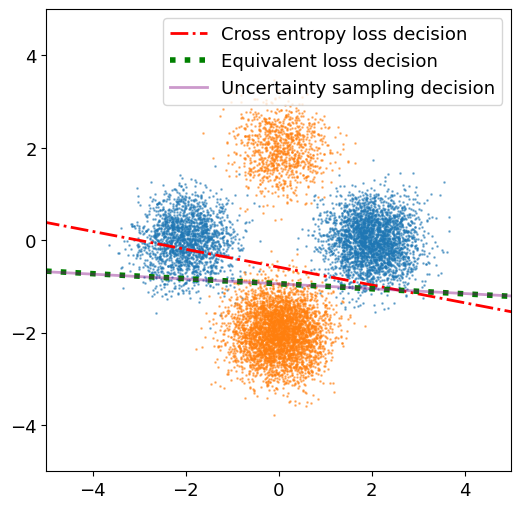

In [15]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 6))
inds = y == 1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'positive')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'negative')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_logistic = (-inter_logistic - theta_logistic[1] * vert_grid) / theta_logistic[0]
plt.plot(hori_logistic, vert_grid, linestyle = 'dashdot', label = 'Cross entropy loss decision', color = 'red', alpha = 1.0, linewidth = 2.0)
# hori_sqhinge = (-inter_sqhinge - theta_sqhinge[1] * vert_grid) / theta_sqhinge[0]
# plt.plot(hori_sqhinge, vert_grid, linestyle = 'dashed', label = 'Squared margin loss decision', color = 'olive', alpha = 1.0, linewidth = 2.0)
hori_eq1_1 = (-inter_eq1_1 - theta_eq1_1[1] * vert_grid) / theta_eq1_1[0]
plt.plot(hori_eq1_1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
# hori_eq1_2 = (-inter_eq1_2 - theta_eq1_2[1] * vert_grid) / theta_eq1_2[0]
# plt.plot(hori_eq1_2, vert_grid, linestyle = 'dotted', color = 'green', alpha = 1.0, linewidth = 2.0)
# hori_eq1_3 = (-inter_eq1_3 - theta_eq1_3[1] * vert_grid) / theta_eq1_3[0]
# plt.plot(hori_eq1_3, vert_grid, linestyle = 'dotted', color = 'green', alpha = 1.0, linewidth = 2.0)
# hori_eq1_4 = (-inter_eq1_4 - theta_eq1_4[1] * vert_grid) / theta_eq1_4[0]
# plt.plot(hori_eq1_4, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
# hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.4, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.savefig("Experiment1-1-1.eps", bbox_inches='tight')
plt.savefig("Experiment1-1-1.jpg", bbox_inches='tight')
plt.show()

In [16]:
theta_eq1, inter_eq1 = erm_equiv(x, y, step_size=3e-2, max_iter = 2e5, uncertain = 'leastconf')

max_iter


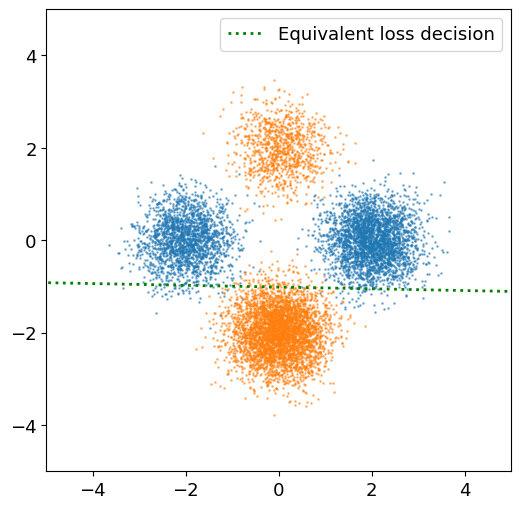

In [17]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [18]:
theta_us1, inter_us1 = uncertain_sampling(x, y, max_iter = 1e7, step_size = 1e-4, init = None, uncertain = 'leastconf')

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [02:46<00:00, 59955.61it/s]


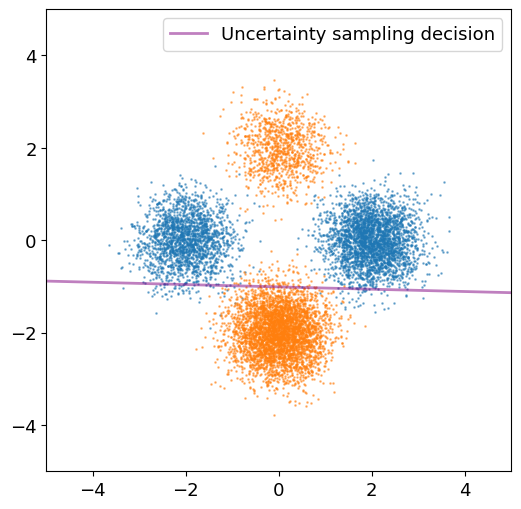

In [19]:
plt.subplots(figsize=(6, 6))
inds = y == 1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.5, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


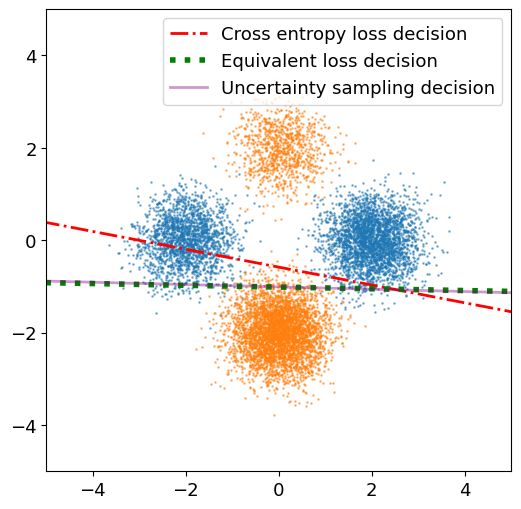

In [20]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(6, 6))
inds = y == 1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'positive')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
inds = y == -1
# plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.6, alpha = 0.5, label = 'negative')
plt.scatter(x = x[inds, 0][:5000], y = x[inds, 1][:5000], s = 0.8, alpha = 0.5)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

vert_grid = np.linspace(-6.0, 6.0, 50)
hori_logistic = (-inter_logistic - theta_logistic[1] * vert_grid) / theta_logistic[0]
plt.plot(hori_logistic, vert_grid, linestyle = 'dashdot', label = 'Cross entropy loss decision', color = 'red', alpha = 1.0, linewidth = 2.0)
hori_eq1 = (-inter_eq1 - theta_eq1[1] * vert_grid) / theta_eq1[0]
plt.plot(hori_eq1, vert_grid, linestyle = 'dotted', label = r'Equivalent loss decision', color = 'green', alpha = 1.0, linewidth = 4.0)
hori_us1 = (-inter_us1 - theta_us1[1] * vert_grid) / theta_us1[0]
plt.plot(hori_us1, vert_grid, linestyle = 'solid', label = r'Uncertainty sampling decision', color = 'purple', alpha = 0.4, linewidth = 2.0)
plt.legend(fontsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.savefig("Experiment1-1-2.eps", bbox_inches='tight')
plt.savefig("Experiment1-1-2.jpg", bbox_inches='tight')
plt.show()